# 1. Initializations and Dataset Download

In [ ]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: omaratef3221
Your Kaggle Key: ··········


100%|██████████| 696M/696M [00:20<00:00, 35.1MB/s]


# 2. Imports
Lets start by getting all our imports, keep in mind that PyTorch is not automatically detects and trains on GPU, you have to tell it to use cuda. In case you want to train on Mac Silicon replace cuda with mps.

In [ ]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac

# 3. Reading Data Paths

The following code will be going through a nested directory structure where images are stored within subdirectories, each directory is representing a specific label (category). It constructs a list of the file paths for these images and their corresponding labels. Then, it creates a pandas DataFrame containing this information, which is useful for further data processing. Keep in mind that we will read all the data and then we will split it again to train, validation and testing.

In [ ]:
image_path = [] # Empty array where we will fill the paths of the images
labels = [] # Empty array where we will fill the labes of the images

for i in os.listdir("/content/animal-faces/afhq/"): # Looping through the first directory which has the train and val images
  for label in os.listdir(f"/content/animal-faces/afhq/{i}"): # Looping through the first directory which has the labels folders
    for image in os.listdir(f"/content/animal-faces/afhq/{i}/{label}"): # Looping through all the images of this label
      labels.append(label) # Append/Put this label in the list
      image_path.append(f"/content/animal-faces/afhq/{i}/{label}/{image}") # Append/Put this image path in the list to read it later

data_df = pd.DataFrame(zip(image_path, labels), columns = ['image_paths', 'labels']) # Create a dataframe contains the images paths and the labels
data_df.head() # Visualizing the first 5 rows

,image_paths,labels
0,/content/animal-faces/afhq/val/cat/pixabay_cat...,cat
1,/content/animal-faces/afhq/val/cat/pixabay_cat...,cat
2,/content/animal-faces/afhq/val/cat/flickr_cat_...,cat
3,/content/animal-faces/afhq/val/cat/flickr_cat_...,cat
4,/content/animal-faces/afhq/val/cat/pixabay_cat...,cat


# 4. Data Split
Now lets split the dataset into training, validation and testing. Here we will be using it in a bit different way since we will be reading the image paths from the dataframe so better we split the dataframe directly and then read the images. We will do that by getting a random sample of 70% from our data using `data_df.sample(frac=0.7,random_state=7)` then we will create a new variable of test dataset which we will drop from it the 70% of the train which means that it will be 30% of the data which is the rest of the data using `data_df.drop(train.index)`. Then we will do the same between testing to create validation which will be 50% of the data which means the final split we have is the following:



*   Training: 70%
*   Validation: 15%
*   Testing: 15%

In [ ]:
train=data_df.sample(frac=0.7,random_state=7) # Create training of 70% of the data
test=data_df.drop(train.index) # Create testing by removing the 70% of the train data which will result in 30%

val=test.sample(frac=0.5,random_state=7) # Create validation of 50% of the testing data
test=test.drop(val.index) # Create testing by removing the 50% of the validation data which will result in 50%

# 5. Custom Dataset Class

In [ ]:
label_encoder = LabelEncoder()

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
    ])

class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(label_encoder.fit_transform(dataframe['labels'])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
          image = self.transform(image).to(device)

        return image, label

In [ ]:
train_dataset = CustomImageDataset(dataframe=train, transform=transform)
val_dataset = CustomImageDataset(dataframe=val, transform=transform)
test_dataset = CustomImageDataset(dataframe=test, transform=transform)

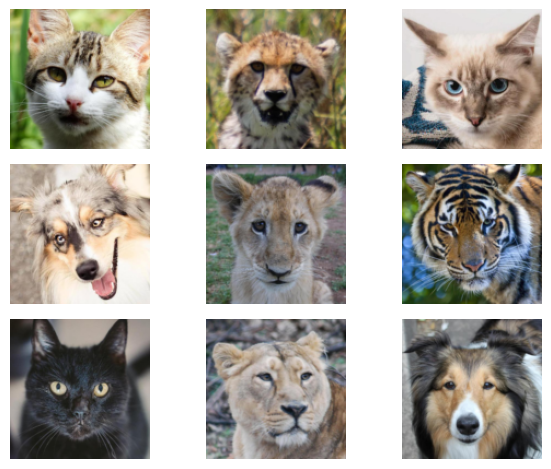

In [ ]:
n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols)
for row in range(n_rows):
    for col in range(n_cols):
        image = train_dataset[np.random.randint(0,train_dataset.__len__())][0].cpu()
        axarr[row, col].imshow(image.squeeze().permute(1,2,0))
        axarr[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
class Net(nn.Module):
    def __init__(self):
      super().__init__()

      self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1)
      self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1)
      self.conv3 = nn.Conv2d(64, 256, kernel_size = 3, stride = 1, padding = 1)
      self.pooling = nn.MaxPool2d(2,2)
      self.relu = nn.ReLU()

      self.flatten = nn.Flatten()
      self.linear = nn.Linear(65536, 128)
      self.output = nn.Linear(128, len(data_df['labels'].unique()))


    def forward(self, x):
      x = self.conv1(x)
      x = self.pooling(x)
      x = self.relu(x)
      x = self.conv2(x)
      x = self.pooling(x)
      x = self.relu(x)
      x = self.conv3(x)
      x = self.pooling(x)
      x = self.relu(x)
      x = self.flatten(x)
      x = self.linear(x)
      x = self.output(x)

      return x

model = Net().to(device)


In [ ]:
from torchsummary import summary
summary(model, input_size = (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 256, 32, 32]         147,712
         MaxPool2d-8          [-1, 256, 16, 16]               0
              ReLU-9          [-1, 256, 16, 16]               0
          Flatten-10                [-1, 65536]               0
           Linear-11                  [-1, 128]       8,388,736
           Linear-12                    [-1, 3]             387
Total params: 8,556,227
Trainable params: 8,556,227
Non-trainable params: 0
---------------------------

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [ ]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []


for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0

  total_loss_val = 0
  total_acc_val = 0
  for (inputs, labels) in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(val_loader):
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  total_acc_validation_plot.append(round(total_acc_val/(val_dataset.__len__())*100, 4))
  print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)} Validation Loss: {round(total_loss_val/100, 4)} Validation Accuracy: {round((total_acc_val)/val_dataset.__len__() * 100, 4)}')


Epoch 1/10, Train Loss: 2.8865 Train Accuracy 83.5178 Validation Loss: 0.3325 Validation Accuracy: 92.314
Epoch 2/10, Train Loss: 1.1034 Train Accuracy 94.6063 Validation Loss: 0.2494 Validation Accuracy: 93.6777
Epoch 3/10, Train Loss: 0.6462 Train Accuracy 96.7408 Validation Loss: 0.2007 Validation Accuracy: 95.0413
Epoch 4/10, Train Loss: 0.413 Train Accuracy 98.087 Validation Loss: 0.1775 Validation Accuracy: 95.9917
Epoch 5/10, Train Loss: 0.2902 Train Accuracy 98.5564 Validation Loss: 0.2419 Validation Accuracy: 94.6694
Epoch 6/10, Train Loss: 0.1986 Train Accuracy 99.1055 Validation Loss: 0.1892 Validation Accuracy: 96.157
Epoch 7/10, Train Loss: 0.1638 Train Accuracy 99.2472 Validation Loss: 0.2729 Validation Accuracy: 95.7851
Epoch 8/10, Train Loss: 0.1211 Train Accuracy 99.3978 Validation Loss: 0.2386 Validation Accuracy: 95.2893
Epoch 9/10, Train Loss: 0.0937 Train Accuracy 99.5926 Validation Loss: 0.2437 Validation Accuracy: 95.9504
Epoch 10/10, Train Loss: 0.0776 Train Acc

In [ ]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for indx, (input, labels) in enumerate(test_loader):

    prediction = model(input)

    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__())*100, 2)}%")

Accuracy Score is: 95.54%


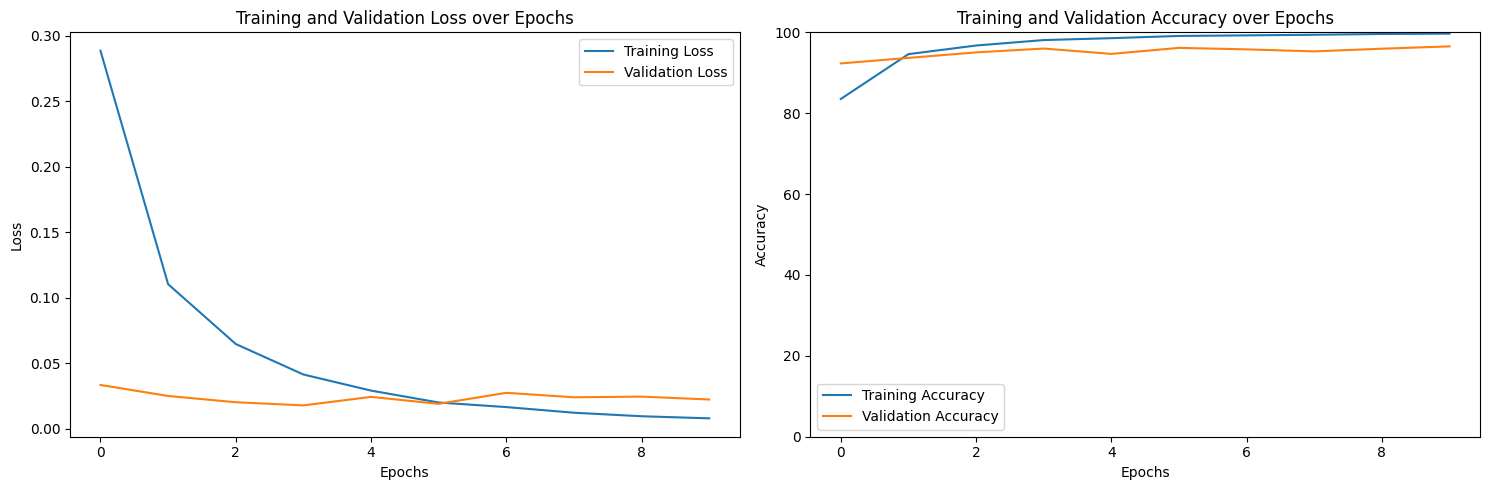

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()